=== ESTADO DEL SISTEMA ===
✅ GPU ACTIVA: /physical_device:GPU:0
🚀 Modo Turbo: ACTIVADO

descargando datos de BTC-USD...


C:\Users\pablo\AppData\Local\Temp\ipykernel_12728\3979340544.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(SYMBOL, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


Datos descargados: 2191 velas diarias.
Dimensiones de entrenamiento: (2131, 60, 1)

Iniciando entrenamiento...
Epoch 1/50
67/67 [==============================] - 4s 12ms/step - loss: 0.0161
Epoch 2/50
67/67 [==============================] - 1s 12ms/step - loss: 0.0035
Epoch 3/50
67/67 [==============================] - 1s 12ms/step - loss: 0.0033
Epoch 4/50
67/67 [==============================] - 1s 12ms/step - loss: 0.0029
Epoch 5/50
67/67 [==============================] - 1s 12ms/step - loss: 0.0030
Epoch 6/50
67/67 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 7/50
67/67 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 8/50
67/67 [==============================] - 1s 11ms/step - loss: 0.0028
Epoch 9/50
67/67 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 10/50
67/67 [==============================] - 1s 12ms/step - loss: 0.0021
Epoch 11/50
67/67 [==============================] - 1s 12ms/step - loss: 0.0021
Epoch 1

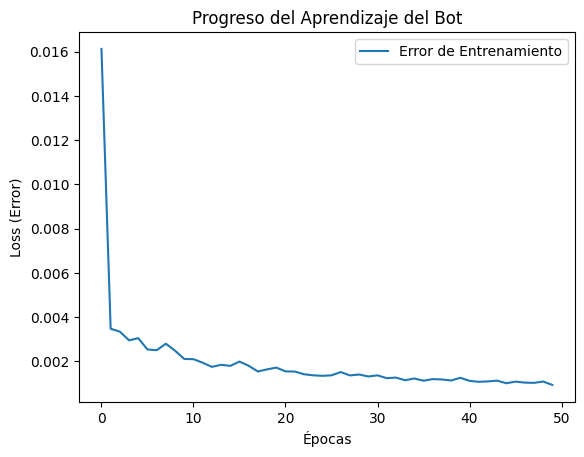

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. CONFIGURACIÓN Y VERIFICACIÓN DE GPU
# ---------------------------------------------------------
# Silenciar advertencias de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("=== ESTADO DEL SISTEMA ===")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU ACTIVA: {gpus[0].name}")
    print("🚀 Modo Turbo: ACTIVADO")
    # Configuración para que la memoria crezca según se necesite y no reserve toda de golpe
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ ADVERTENCIA: Usando CPU. El entrenamiento será lento.")
print("==========================\n")

# ---------------------------------------------------------
# 2. OBTENCIÓN DE DATOS (DATA PIPELINE)
# ---------------------------------------------------------
SYMBOL = 'BTC-USD'
START_DATE = '2018-01-01'
END_DATE = '2024-01-01'

print(f"descargando datos de {SYMBOL}...")
df = yf.download(SYMBOL, start=START_DATE, end=END_DATE)

# Usaremos solo el precio de 'Cierre' (Close) para empezar
data = df['Close'].values.reshape(-1, 1)

print(f"Datos descargados: {len(data)} velas diarias.")

# ---------------------------------------------------------
# 3. PREPROCESAMIENTO (LA MAGIA)
# ---------------------------------------------------------
# A. Escalado: Las redes neuronales funcionan mejor con números entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# B. Creación de Ventanas (Time Steps)
# La red mirará 60 días hacia atrás para predecir el día 61
PREDICTION_DAYS = 60

x_train, y_train = [], []

for x in range(PREDICTION_DAYS, len(scaled_data)):
    x_train.append(scaled_data[x-PREDICTION_DAYS:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape para formato LSTM: [Muestras, Pasos de Tiempo, Features]
# Tu GPU necesita recibir los datos en 3 Dimensiones
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(f"Dimensiones de entrenamiento: {x_train.shape}")

# ---------------------------------------------------------
# 4. ARQUITECTURA DEL MODELO (EL CEREBRO)
# ---------------------------------------------------------
model = Sequential()

# Capa 1: LSTM con retorno de secuencias (Memoria Profunda)
# return_sequences=True es vital para conectar con otra capa LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2)) # Apagamos 20% neuronas al azar para evitar que memorice de memoria

# Capa 2: LSTM Intermedia
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Capa 3: LSTM Final (Condensa la memoria)
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Capa de Salida: Predicción del precio (1 solo número)
model.add(Dense(units=1))

# Compilación
model.compile(optimizer='adam', loss='mean_squared_error')

# ---------------------------------------------------------
# 5. ENTRENAMIENTO (AQUÍ RUGE LA 2060)
# ---------------------------------------------------------
# Callbacks: Guardar el mejor modelo y parar si no mejora
callbacks = [
    EarlyStopping(monitor='loss', patience=5, verbose=1),
    ModelCheckpoint('modelo_btc_v1.h5', monitor='loss', save_best_only=True)
]

print("\nIniciando entrenamiento...")
# epochs=50: Intentará aprender 50 veces sobre los datos
# batch_size=32: Procesará 32 días de golpe (paralelismo GPU)
history = model.fit(x_train, y_train, epochs=50, batch_size=32, callbacks=callbacks)

# ---------------------------------------------------------
# 6. GUARDAR Y VISUALIZAR
# ---------------------------------------------------------
print("\nModelo guardado como 'modelo_btc_v1.h5'")

# Gráfico de pérdida (Loss) para ver qué tan bien aprendió
plt.plot(history.history['loss'], label='Error de Entrenamiento')
plt.title('Progreso del Aprendizaje del Bot')
plt.xlabel('Épocas')
plt.ylabel('Loss (Error)')
plt.legend()
plt.show()